In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pickle
import collections

In [81]:
NUM_FILTERS = 32 * 4
SPEC_HEIGHT = 32
HWW_X = 10
WIGGLE_ROOM = 5
CONV_FILTER_WIDTH = 4
channels = 4
NUM_DENSE_UNITS = 128 * 4

np.random.seed(10)
input_data = np.random.rand(12, channels, SPEC_HEIGHT, HWW_X*2).astype(np.float32)
print(input_data.shape)

(12, 4, 32, 20)


In [82]:
weights = pickle.load(open('weights/weights_99.pkl', 'rb'), encoding='latin1')
for xx in weights:
    print(xx.shape)

(128, 4, 27, 4)
(128,)
(128,)
(128,)
(128,)
(128, 128, 1, 3)
(128,)
(128,)
(128,)
(128,)
(768, 512)
(512,)
(512,)
(512,)
(512,)
(512, 512)
(512,)
(512,)
(512,)
(512,)
(512, 2)
(2,)


# Theano

In [84]:
import theano
import lasagne

from lasagne.layers import InputLayer, DimshuffleLayer, DenseLayer, DropoutLayer, NonlinearityLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.layers import batch_norm
from lasagne.nonlinearities import softmax, very_leaky_rectify as vlr

# batch_norm = lambda x:x
net = {}
net['input'] = InputLayer((None, channels, SPEC_HEIGHT, HWW_X*2), name='input')
net['conv1_1'] = batch_norm(
    ConvLayer(net['input'], NUM_FILTERS, (SPEC_HEIGHT - WIGGLE_ROOM, CONV_FILTER_WIDTH), nonlinearity=vlr, b=None))

net['pool1'] = net['conv1_1'] 
net['conv1_2'] = batch_norm(
    ConvLayer(net['pool1'], NUM_FILTERS, (1, 3), nonlinearity=vlr))
W = net['conv1_2'].output_shape[3]
net['pool2'] = PoolLayer(net['conv1_2'], pool_size=(1, W), stride=(1, 1), mode='max')

net['fc6'] = batch_norm(DenseLayer(net['pool2'], num_units=NUM_DENSE_UNITS, nonlinearity=vlr))
net['fc7'] = batch_norm(DenseLayer(net['fc6'], num_units=NUM_DENSE_UNITS, nonlinearity=vlr))
net['fc8'] = DenseLayer(net['fc7'], num_units=2, nonlinearity=vlr)
net['prob'] = NonlinearityLayer(net['fc8'], softmax)

lasagne.layers.set_all_param_values(net['prob'], weights)

test_output = lasagne.layers.get_output(net.values(), deterministic=True)
pred_fn = theano.function([net['input'].input_var], test_output)

theano_pred = pred_fn(input_data)
theano_pred = collections.OrderedDict((k, v) for k, v in zip(net.keys(), theano_pred))

print(theano_pred.keys())
print(theano_pred["fc7"].shape)

odict_keys(['input', 'conv1_1', 'pool1', 'conv1_2', 'pool2', 'fc6', 'fc7', 'fc8', 'prob'])
(12, 512)


(12, 2)
0.23979701226077144


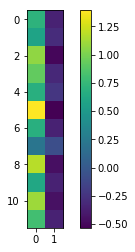

In [85]:
test_key = 'fc8'
layer2d = False

print(theano_pred[test_key].shape)
if layer2d:
    plt.imshow(theano_pred[test_key][0, 0])
else:
    plt.imshow(theano_pred[test_key][:, :100])
    print(theano_pred[test_key][:, :100].mean())
plt.colorbar()

# TF

In [86]:
import collections
import tensorflow as tf
from tensorflow import layers
from tensorflow.contrib import slim

In [88]:
tf.reset_default_graph()

tf_net = collections.OrderedDict()


class BatchNormFeedforward(tf.keras.layers.Layer):
    def __init__(self, name, beta, gamma, mean, inv_std):
        super(BatchNormFeedforward, self).__init__()
        self.bn_mean_0 = tf.get_variable("bn_mean_" + name, initializer=mean[None, None, None, :])
        self.inv_std_0 = tf.get_variable("inv_std_" + name, initializer=inv_std[None, None, None, :])
        self.gamma_0 = tf.get_variable("gamma_" + name, initializer=gamma[None, None, None, :])
        self.beta_0 = tf.get_variable("beta_" + name, initializer=beta[None, None, None, :])

    def call(self, input):
        return (input - self.bn_mean_0) * (self.gamma_0 * self.inv_std_0) + self.beta_0
    

bn0 = BatchNormFeedforward("0", *weights[1:5])
bn1 = BatchNormFeedforward("1", *weights[6:10])
bn2 = BatchNormFeedforward("2", *weights[11:15])
bn3 = BatchNormFeedforward("3", *weights[16:20])
    
tf_net['input'] = tf.placeholder(
    tf.float32, (None, SPEC_HEIGHT, HWW_X*2, channels), name='input')
tf_net['conv1_1'] = slim.conv2d(
    tf_net['input'], NUM_FILTERS, (SPEC_HEIGHT - WIGGLE_ROOM, CONV_FILTER_WIDTH), 
    padding='valid', activation_fn=None, biases_initializer=None)
tf_net['conv1_1'] = bn0(tf_net['conv1_1'])
tf_net['conv1_1'] = tf.nn.leaky_relu(tf_net['conv1_1'], alpha=1/3)

tf_net['conv1_2'] = slim.conv2d(
    tf_net['conv1_1'], NUM_FILTERS, (1, 3), padding='valid', 
    activation_fn=None, biases_initializer=None)
tf_net['conv1_2'] = bn1(tf_net['conv1_2'])
tf_net['conv1_2'] = tf.nn.leaky_relu(tf_net['conv1_2'], alpha=1/3)

W = tf_net['conv1_2'].shape[2]
tf_net['pool2'] = slim.max_pool2d(
    tf_net['conv1_2'], kernel_size=(1, W), stride=(1, 1))


tf_net['pool2'] = tf.transpose(tf_net['pool2'], (0, 3, 2, 1))
tf_net['pool2_flat'] = slim.flatten(tf_net['pool2'])

tf_net['fc6'] = slim.fully_connected(
    tf_net['pool2_flat'], NUM_DENSE_UNITS, 
    activation_fn=None, biases_initializer=None)
tf_net['fc6'] = bn2(tf_net['fc6'])
tf_net['fc6'] = tf.nn.leaky_relu(tf_net['fc6'], alpha=1/3)

tf_net['fc7'] = slim.fully_connected(
    tf_net['fc6'], NUM_DENSE_UNITS, 
    activation_fn=None, biases_initializer=None)
tf_net['fc7'] = bn3(tf_net['fc7'])
tf_net['fc7'] = tf.nn.leaky_relu(tf_net['fc7'], alpha=1/3)


tf_net['fc8'] = slim.fully_connected(tf_net['fc7'], 2, activation_fn=None)
tf_net['fc8'] = tf.nn.leaky_relu(tf_net['fc8'], alpha=1/3)

Conv/weights:0 (27, 4, 4, 128)
Conv_1/weights:0 (1, 3, 128, 128)
fully_connected/weights:0 (768, 512)
fully_connected_1/weights:0 (512, 512)
fully_connected_2/weights:0 (512, 2)
fully_connected_2/biases:0 (2,)
(12, 32, 20, 4) (1, 1, 12, 2)
(1, 1, 12, 2)


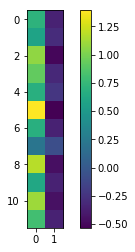

In [90]:
input_data_tf = input_data.transpose(0, 2, 3, 1)

# list of tensorflow names corresponding to each value in pickle file
var_mapper = {
    "Conv/weights:0": weights[0],
    "Conv_1/weights:0": weights[5],
    "fully_connected/weights:0": weights[10],
    "fully_connected_1/weights:0": weights[15],
    "fully_connected_2/weights:0": weights[20],
    "fully_connected_2/biases:0": weights[21]
}

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for var in tf.global_variables():
        if var.name in var_mapper:
            value = var_mapper[var.name]
            if len(value.shape) == 4:
                _value = value.transpose(2, 3, 1, 0)[::-1, ::-1]
            else:
                _value = value.copy()

            print(var.name, _value.shape)
            sess.run(var.assign(_value))

# with tf.Session() as sess:
    tf_pred = sess.run(tf_net[test_key], feed_dict={tf_net['input']: input_data_tf})
#     print(tf_pred.shape)
    if layer2d:
        tf_pred = tf_pred.transpose(0, 3, 1, 2)
    print(input_data_tf.shape, tf_pred.shape)
    
print(tf_pred.shape)
if layer2d:
    plt.imshow(tf_pred[0, 0])
elif test_key in ['fc7', 'fc8']:
    plt.imshow(tf_pred.squeeze()[:, :100])
else:
    plt.imshow(tf_pred[:, :100])

plt.colorbar()

# Plotting % "error"

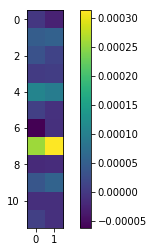

In [80]:
if layer2d:
    A = theano_pred[test_key][0, 0]
    B = tf_pred[0, 0]
else:
    A = theano_pred[test_key]
    B = tf_pred.squeeze()

err = (A - B) / A * 100
plt.imshow(err[:, :100])
plt.colorbar()